In [5]:
import plotly.graph_objs as go
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

df = pd.read_csv("../data/processed/latent_vector_3_with_euclidian_distance.csv")
df

,0,1,2,year,country,distance
0,-0.735218,-0.571674,0.032627,2002,PAN,3.220611
1,-0.307041,0.533277,-0.911131,2002,IND,3.574451
2,-0.307043,0.533278,-0.911131,2002,MDV,3.574452
3,-0.134919,0.917182,1.994382,2002,DJI,3.730729
4,2.181142,-1.938499,0.000992,2002,NLD,0.714185
...,...,...,...,...,...,...
1133,-0.531939,-1.597773,-0.914468,2007,AGO,3.305762
1134,-0.735213,-0.571683,0.032628,2007,AUT,2.506619
1135,-0.307038,0.533280,-0.911131,2007,MNE,3.464766
1136,-0.307041,0.533277,-0.911130,2007,FJI,3.464766


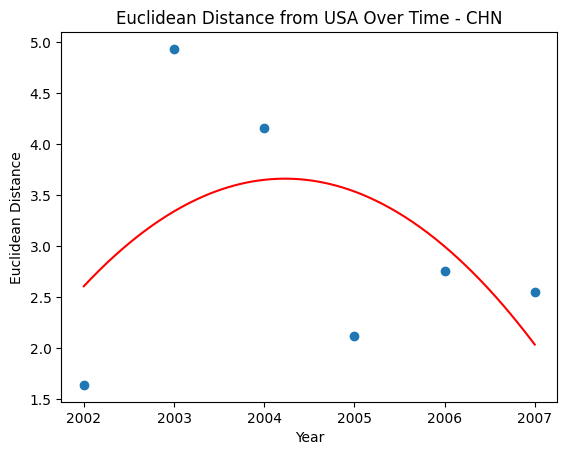

In [12]:
# Filter for a specific country (e.g., 'FRA')
country = 'CHN'
country_data = df[df['country'] == country]

# Group by year and calculate the average distance for each year (handling duplicates)
country_data_avg = country_data.groupby('year').agg({'distance': 'mean'}).reset_index()

# Extract the years and averaged distances
years = country_data_avg['year']
distances = country_data_avg['distance']

# Plot the scatter points
plt.scatter(years, distances)

# Generate a smooth curve
years_smooth = np.linspace(years.min(), years.max(), 300)  # More points for smoothness

# Use np.polyfit to fit a polynomial of degree 2 for a smooth line
z = np.polyfit(years, distances, 2)
p = np.poly1d(z)

# Plot the fitted smooth curve
plt.plot(years_smooth, p(years_smooth), 'r')

# Set the title and labels
plt.title(f'Euclidean Distance from USA Over Time - {country}')
plt.xlabel('Year')
plt.ylabel('Euclidean Distance')

# Show the plot
plt.show()

In [4]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess

# Initialize Plotly figures for each country
figures = {}
countries = df["country"].unique()
for country in countries:
    filtered_df = df[df["country"] == country]
    years = filtered_df["year"].tolist()
    distances = filtered_df["distance"].tolist()
    # Calculate trendline using lowess
    lowess_results = lowess(distances, years, frac=1)
    trendline_years = [point[0] for point in lowess_results]
    trendline_distances = [point[1] for point in lowess_results]

    fig = go.Figure(
        data=[
            go.Scatter(
                x=years,
                y=distances,
                mode="markers",
                name=country,
                marker=dict(size=10),
            ),
            go.Scatter(
                x=trendline_years,
                y=trendline_distances,
                mode="lines",
                name=f"{country} Trendline",
                line=dict(color="red"),
            ),
        ]
    )
    fig.update_layout(
        title=f"Euclidian Distance from USA Over Time - {country}",
        xaxis=dict(tickmode="array", tickvals=years, title="Year"),
        yaxis=dict(title="Euclidian Distance"),
    )
    figures[country] = fig

# Prepare data and layout for JSON serialization
data_json = {
    country: figures[country].to_plotly_json()["data"] for country in countries
}
layout_json = {
    country: json.loads(json.dumps(figures[country].to_plotly_json()["layout"]))
    for country in countries
}

In [5]:
# Sort countries and generate option elements for each country
option_elements = "\n".join(
    f'<option value="{country}">{country}</option>' for country in sorted(countries)
)

# Generate HTML
html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
    <title>Diffusion Distance from USA Over Time</title>
</head>
<body>
    <h1>Diffusion Distance from USA Over Time</h1>
    <label for="country">Select Country:</label>
    <select id="country" onchange="updatePlot()">
        {option_elements}
    </select>
    <div id="plot"></div>
    <script>
        var data = {json.dumps(data_json, default=str)};
        var layout = {json.dumps(layout_json, default=str)};

        function updatePlot() {{
            var selectedCountry = document.getElementById("country").value;
            var plotData = data[selectedCountry];
            var plotLayout = layout[selectedCountry];
            Plotly.react('plot', plotData, plotLayout);
        }}

        document.addEventListener("DOMContentLoaded", function() {{
            updatePlot(); // Initialize the plot with the default selection
        }});
    </script>
</body>
</html>
"""

# Save HTML file
with open("../data/processed/UN_dropdown_euclidian_distance.html", "w") as f:
    f.write(html_content)